<a href="https://colab.research.google.com/github/martinpovolny/colaboratory/blob/master/Cars_vs_trucks_w__validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we download and unzip the data. The data comes in sorted into subdirectories by categories.

For sorting I first used: https://github.com/martinpovolny/clsf and manually fixed bugz.

In [1]:
!wget http://ujc.hmpf.cz/download/cars-sorted-2019-06-01.zip  -O /tmp/cars-sorted.zip

--2019-06-01 12:39:42--  http://ujc.hmpf.cz/download/cars-sorted-2019-06-01.zip
Resolving ujc.hmpf.cz (ujc.hmpf.cz)... 147.231.205.34
Connecting to ujc.hmpf.cz (ujc.hmpf.cz)|147.231.205.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66101608 (63M) [application/zip]
Saving to: ‘/tmp/cars-sorted.zip’

/tmp/cars-sorted.zi 100%[===================>]  63.04M  11.2MB/s    in 6.6s    

2019-06-01 12:39:49 (9.59 MB/s) - ‘/tmp/cars-sorted.zip’ saved [66101608/66101608]



In [0]:
import os
import zipfile

local_zip = '/tmp/cars-sorted.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/cars-sorted')
zip_ref.close()

In [0]:
train_dir = os.path.join('/tmp/cars-sorted/sorted')


I am downscaling the images to 90x160. Seems to be enough to tell car from a truck and front from rear.

In [0]:
image_size=(90, 160)

Common approach (tutorials, courses) is having the train and validation data in separate directories. I have the data from the same source and would have to split it manually or write some code to split it to use that approach.

So for having train and validation data in the same directory I am using this: https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
# FIXME: loss_weights?
batch_size = 128

train_datagen = ImageDataGenerator(rescale=1./255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data



Found 3578 images belonging to 5 classes.
Found 893 images belonging to 5 classes.


In [0]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Sequential;
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation;

In [0]:
def model_4(image_size, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(image_size[0], image_size[1], 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))

    return model


In [13]:
model = model_4(image_size, 5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
from tensorflow.keras.optimizers import Adam, RMSprop

#model.compile(loss='binary_crossentropy',
#              optimizer=RMSprop(lr=0.001),
#              metrics=['acc'])

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    loss_weights=None,
    sample_weight_mode=None,
    weighted_metrics=None,
    target_tensors=None)


In [15]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
28/28 [==============================] - 9s 324ms/step - loss: 1.2619 - acc: 0.5162 - val_loss: 0.9867 - val_acc: 0.6674
Epoch 2/15
28/28 [==============================] - 6s 206ms/step - loss: 0.9064 - acc: 0.6621 - val_loss: 0.9623 - val_acc: 0.6159
Epoch 3/15
28/28 [==============================] - 6s 208ms/step - loss: 0.6815 - acc: 0.7462 - val_loss: 0.8697 - val_acc: 0.6853
Epoch 4/15
28/28 [==============================] - 6s 207ms/step - loss: 0.5648 - acc: 0.7879 - val_loss: 0.8736 - val_acc: 0.6954
Epoch 5/15
28/28 [==============================] - 6s 206ms/step - loss: 0.4994 - acc: 0.8069 - val_loss: 0.6169 - val_acc: 0.7548
Epoch 6/15
28/28 [==============================] - 6s 206ms/step - loss: 0.4638 - acc: 0.8234 - val_loss: 0.7636 - val_acc: 0.7223
Epoch 7/15
28/28 [==============================] - 6s 205ms/step - loss: 0.4069 - acc: 0.8399 - val_loss: 0.5981 - val_acc: 0.7794
Epoch 8/15
28/28 [==========

In [0]:
import matplotlib.pyplot as plt

def plot_accuracy_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


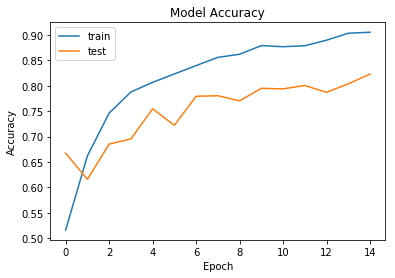

In [19]:
plot_accuracy_history(history)

In [0]:
class_labels = (train_generator.class_indices)
class_labels = dict((v,k) for k,v in class_labels.items())

def from_categorical(x):
    return class_labels[np.argmax(x, axis=0)]

In [0]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=image_size)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(from_categorical(classes[0]))


Saving prijezd.down-1549009087-p.jpg to prijezd.down-1549009087-p.jpg
predek_osobni
